# Content-Based Image Retrieval 

Implementing a very simple **content based image search system** and **evaluating its performance**. The dataset used is **U. Kentucky Benchmark Image Database**.

**NOTE:** The dataset won't be posted on the GitHub, you could use the link to download the dataset: http://www.ee.columbia.edu/~rj2349/index_files/Homework1/

**The dataset should be placed in** *data/hw1* directory in order for IPython Notebook to work correctly.

The original database includes 2,550 objects with 4 images for each object (total of 10,200 images). The images were taken to simulate variations of lighting, view, occlusion, scale, etc.

## Problems

- Write a program to extract the color histogram of each of the 2,000 images. Choose the parameters required with justifications. Implement your own histogram code and compare its results with open-source API like OpenCV and numpy.

- Write a program to measure the L2 distance between color histograms of two images.

- Use 5 images shown above (ukbench00004.jpg; ukbench00040.jpg; ukbench00060.jpg; ukbench00588.jpg; ukbench01562.jpg) as queries. For each query image, find 10 best matches from the 2,000 images based on the color histogram similarity. Plot the query image and the 10 returned matches (use icons of reduced resolution to save space)

- Write a program to measure and plot the P-R curve for each query

- Discuss and explain success and failure cases.

- (Optional) try to improve the results by using a different feature or distance metrics (bag of words, 3d-color histograms etc) of your choice. Justify your choice with qualitative reasons and back it up with performance comparison results.

In [13]:
import cv2
import numpy as np
import os 
import matplotlib.pyplot as plt

In [14]:
%matplotlib inline

In [24]:
# Path constants
work_dir_path = os.getcwd()
data_dir_path = os.path.join(work_dir_path, 'data')

# Please pay attention that the downloaded dataset should be in this folder
dataset_dir_path = os.path.join(data_dir_path, 'hw_1')

## Helper functions

All helper functions and core functions would be moved into separate pyscript in the folder *helpers/content_based_helper.py*

In [33]:
def read_image(img_name):
    return cv2.imread(get_img_abs_path(img_name))

def get_img_abs_path(img_name):
    return os.path.join(dataset_dir_path, img_name)

## Problem 1. Extract color histogram from the image

In [94]:
def color_hist(image):
    """
    Creates a color histogram of the input image
    
    Input:
    image - matrix, input image matrix
    
    Output:
    hist - numpy array consisting of 256 values, each will indicate
    the number of occurences of pixel intensity
    
    TODO: Grayscale images
    """
    
    hist = np.zeros(256)
    
    flat_img = image.ravel()
    
    # Iterate over each pixel
    for pixel in flat_img:
        # Increment the occurence of pixel value
        hist[pixel] += 1
    
    return hist

## Testing the color histogram solution

In [95]:
# Let's load a sample image and compute it's color histogram
test_img = read_image(os.listdir(dataset_dir_path)[-1])
test_hist = color_hist(test_img)

In [96]:
# Let's use numpy solution for comparison
np_hist = np.histogram(test_img.ravel(), 256, [0,256])

In [97]:
# Now let's compare two vectors
print("Custom solution returns the same result as NumPy solution: ", (test_hist == np_hist[0]).all())

Custom solution returns the same result as NumPy solution:  True


## Problem 2. L2 distance between color histograms

In [107]:
def l2_dist(hist1, hist2):
    """
    Computes L2 distance between two numpy vectors/matrices
    
    Input:
    hist1, hist2 - numpy vectors/matrices to compute distance between
    
    Output:
    distance - scalar value showing distance between two vectors/matrices
    """
    distance = np.sum(np.abs(hist1 - hist2))
    
    return distance

## Problem 3. Finding best matches for query images

### First of all we need to compute the color histogram for each of 2000 images. This process may take significant amount of time, so be patient.

In [134]:
def compute_color_hist_for_all_images(images_path, log = True):
    """
    Computes the color histogram for all images from the data folder
    and returns two arrays image_names, image_names_color_hists
    
    Input:
    images_path - string, absolute path to images directory
    log - boolean, whether to print how many images already processed
    """
        
    # Variable for indicating the current processed image
    processed_image = 0
    
    # List of image names
    image_names_list = os.listdir(images_path)
    image_names_len = len(image_names_list)
    
    # Create empty two empty lists for image names and corresponding histograms
    image_names = []
    color_hists = []
    

    # Iterate over each image
    for index, image_name in enumerate(image_names_list):
    
        # Set the corresponding values in arrays
        image_names.append(image_name)
        color_hists.append(color_hist(read_image(image_name)))
        
        processed_image += 1
        if(log and (processed_image % 100 == 0)):
            print("Processed %d of %d images" % (processed_image, image_names_len))     
        
        
    return image_names, color_hists

In [135]:
image_names, image_colors_hists = compute_color_hist_for_all_images(True, dataset_dir_path)

Processed 20 of 2000 images
Processed 40 of 2000 images
Processed 60 of 2000 images
Processed 80 of 2000 images
Processed 100 of 2000 images
Processed 120 of 2000 images
Processed 140 of 2000 images
Processed 160 of 2000 images
Processed 180 of 2000 images
Processed 200 of 2000 images
Processed 220 of 2000 images
Processed 240 of 2000 images
Processed 260 of 2000 images
Processed 280 of 2000 images
Processed 300 of 2000 images
Processed 320 of 2000 images
Processed 340 of 2000 images
Processed 360 of 2000 images
Processed 380 of 2000 images
Processed 400 of 2000 images
Processed 420 of 2000 images
Processed 440 of 2000 images
Processed 460 of 2000 images
Processed 480 of 2000 images
Processed 500 of 2000 images
Processed 520 of 2000 images
Processed 540 of 2000 images
Processed 560 of 2000 images
Processed 580 of 2000 images
Processed 600 of 2000 images
Processed 620 of 2000 images
Processed 640 of 2000 images
Processed 660 of 2000 images
Processed 680 of 2000 images
Processed 700 of 2

In [238]:
query_images = ['ukbench00004.jpg', 'ukbench00040.jpg', 
                'ukbench00060.jpg', 'ukbench00588.jpg', 'ukbench01560.jpg']

In [239]:
def compute_query_for_image(query_image_name, image_names, image_colors_hists, k = 10):
    """
    Computes L2 distance between query_image_name and each of image_names entries
    
    Input:
    query_image_name - string, name of the image to be queried on
    image_names - list, list of image names
    image_colors_hists - list, list of corresponding to image_names entries color histograms by index
    k - int, indicates how many best matches should be searched for query_image_name
    
    Output:
    (query_image_name, k_best_matches_names) - tuple, best_matches is a list containing names of k-best matched images
    
    """
    
    # Empty array to store l2 distances from target image to all other images
    l2_distances = np.zeros(len(image_names))
    
    # Target image color histogram
    target_hist = color_hist(read_image(query_image_name))
    
    
    # Iterate over each of the image_color_hists entries
    for index, image_hist in enumerate(image_colors_hists):
        l2_distances[index] = l2_dist(target_hist, image_hist) 
        
        # A small hack to remove self-duplicate
        if(l2_distances[index] == 0):
            l2_distances[index] = 10000000
        
    
    # Find k-indicies of the best matches
    k_best_matches = np.argpartition(l2_distances, k)[:k]
    
    # Get names of k-best matched indicies
    k_best_matches_names = [image_names[i] for i in k_best_matches]
    
    return (query_image_name, k_best_matches_names)  

In [240]:
def plot_target_query_and_results(query_image_test_name, k_best_test_matches, columns = 4, rows = 3):
    """
    Plots the target query image alongside with k-best image matches
    
    Input:
    query_image_test_name - string, name of the target query image file
    k_best_test_matches - list, containing string names of best k-matches
    columns, rows - int, adjustable parameters of figure subplots location
    
    Output:
    Displays a figure with subplots.
    """
    
    # Create figure for plotting several images
    fig=plt.figure(figsize=(7, 7))
    
    # Add query image
    fig.add_subplot(rows, columns, 1)
    plt.axis('off')
    plt.title("Target image", fontsize = 10)
    plt.imshow(read_image(query_image_test_name))
    
    # Add all best k-matches images
    for i in range(1, len(k_best_test_matches)):
        img = read_image(k_best_test_matches[i])
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(k_best_test_matches[i], fontsize = 10)
        plt.imshow(img)
        
    plt.show()

In [241]:
def compute_k_best_hist_matches_and_plot(query_image_name, image_names, image_colors_hists, k = 10):
    """
    Function that combines the call for compute_query_for_image and plot_target_query_and_results
    """
    
    img_query, k_best_matches = compute_query_for_image(query_image_name, image_names, image_colors_hists)
    plot_target_query_and_results(img_query, k_best_matches)

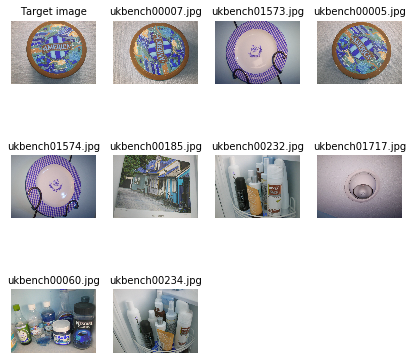


-------------------------------------------------------------------- 



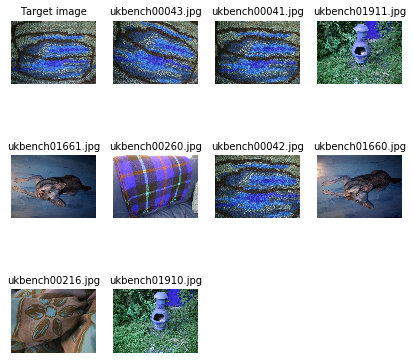


-------------------------------------------------------------------- 



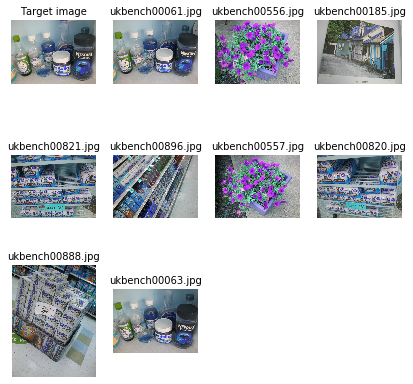


-------------------------------------------------------------------- 



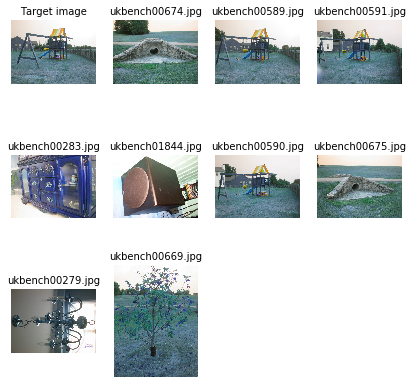


-------------------------------------------------------------------- 



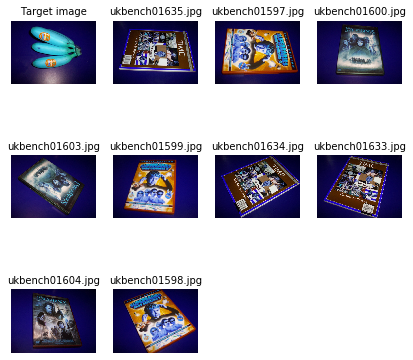


-------------------------------------------------------------------- 



In [242]:
for query_img_name in query_images:
    compute_k_best_hist_matches_and_plot(query_img_name, image_names, image_colors_hists)
    print("\n-------------------------------------------------------------------- \n")